# TP2 - VP1
### Andrés Merli

Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para
filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada
de Fourier.
1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una
imagen para validar el funcionamiento en el dominio espectral.
2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency
Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.
3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of
focus measure operators in shape-from-focus”


In [1]:
#%matplotlib inline  

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

### Levantamos la imagen que utlizaremos para validar el funcionamiento

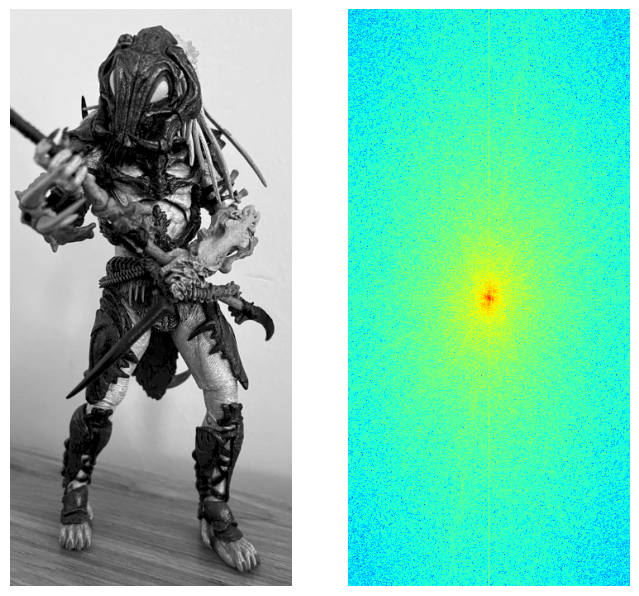

In [58]:
img = cv.imread('fft_alfa_pred.png', cv.IMREAD_GRAYSCALE)
img_tf = 20*np.log(np.abs(np.fft.fftshift(np.fft.fft2(img))))
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(img_tf, cmap='jet')

In [59]:
img.shape

(698, 341)

### Creamos la función que retorna un filtro gaussiano de tamaño HxW y su transformada de Fourier

In [45]:
def create_gauss_filter(h, w, k_size=15, sigma=5):
    space_kernel = np.zeros((h, w))
    kernel_g = cv.getGaussianKernel(ksize=k_size, sigma=sigma)
    kernel_matrix = kernel_g * kernel_g.T
    y_center = (h // 2) - round(k_size / 2)
    x_center = (w // 2) - round(k_size / 2)
    space_kernel[y_center:y_center+k_size, x_center:x_center+k_size] = kernel_matrix
    kernel_tf = np.fft.fft2(space_kernel)
    return space_kernel, kernel_tf
    

Creamos filtros para el tamaño de la imagen para testing (698,341) 

In [60]:
kernel, kernel_tf = create_gauss_filter(698, 341, k_size=15, sigma=3)

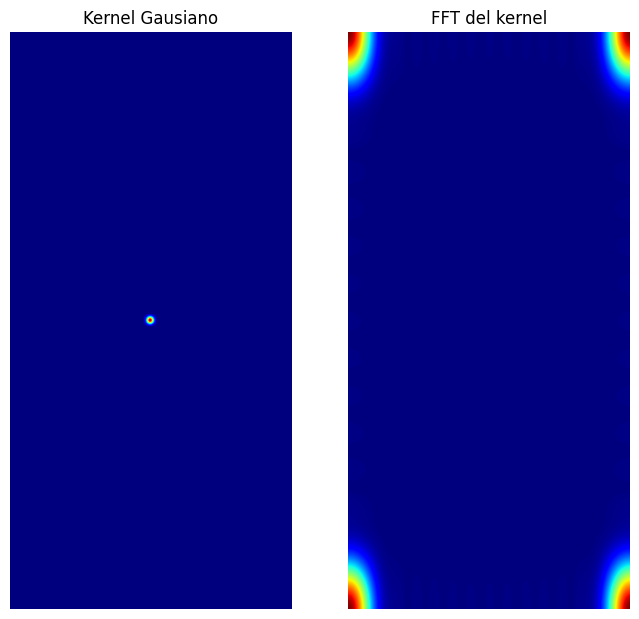

In [61]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Kernel Gausiano")
plt.imshow(kernel, cmap='jet')
plt.subplot(1,2,2)
plt.axis('off')
plt.title("FFT del kernel")
plt.imshow(np.abs(kernel_tf), cmap='jet')

Graficamos el kernel transformado de manera que quede centrado

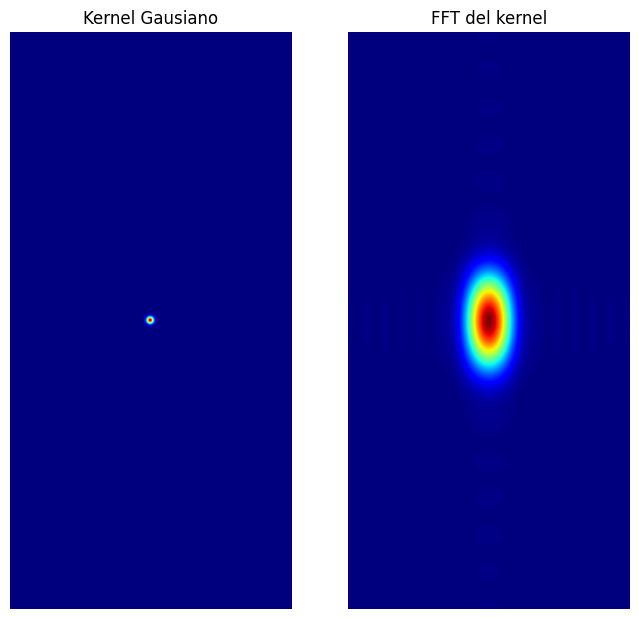

In [62]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Kernel Gausiano")
plt.imshow(kernel, cmap='jet')
plt.subplot(1,2,2)
plt.axis('off')
plt.title("FFT del kernel")
plt.imshow(np.abs(np.fft.fftshift(kernel_tf)), cmap='jet')

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(mod, cmap='jet')

In [ ]:
h, w = img.shape
lp_filter = create_lp_filter(h, w, radius=40)
hp_filter = create_hp_filter(h, w, radius=20)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(lp_filter, cmap='gray')
plt.title('Pasa bajos')
plt.subplot(1,2,2)
plt.title('Pasa altos')
plt.imshow(hp_filter, cmap='gray')

In [ ]:
kernel, kernel_tf = create_gauss_filter(h, w, k_size=15, sigma=3)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Kernel Gausiano")
plt.imshow(kernel, cmap='jet')
plt.subplot(1,2,2)
plt.axis('off')
plt.title("FFT del kernel")
plt.imshow(np.abs(kernel_tf), cmap='jet')

# se puede centrar (shiftear) el grafico del kernel_tf para que quede bien fachero

In [ ]:
# hay que multiplicar la imagen (transformada) con la transformada del filtro y aplico la antitransformada
# como resultado se debe ver una imagen blurreada

img_fft = np.fft.fft2(img)
filtered = img_fft * kernel_tf

#img_gauss = np.real(np.fft.ifft2(np.fft.ifftshift(filtered)))
img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

plt.figure(figsize=(8,8))
plt.imshow(img_gauss, cmap='gray')
plt.title('Desenfoque gausiano')